In [1]:
import pandas as pd
import mne
import matplotlib.pyplot as plt
import numpy as np

Paper uses "Version that was downsampled to 128 Hz and filtered by a band-pass filter with cut-off frequencies of 4 and 45"\
Using pruned dataset having ICA done with filter of 0.5-40 Hz sampled at 128Hz

In [2]:
df=pd.read_csv("/Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Emotions_Train.csv")
train_df=df[["id","label"]]
train_df

,id,label
0,3784258358,0
1,2395445698,2
2,3049220457,3
3,2667905835,3
4,1281311748,0
...,...,...
218,7081425536,1
219,5527955318,1
220,1424199427,0
221,3966019638,3


Opening raw data file /Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Dataset/eremus_dataset/pruned/train/3784258358_eeg.fif...
    Range : 9361 ... 19600 =     73.133 ...   153.125 secs
Ready.
Reading 0 ... 10239  =      0.000 ...    79.992 secs...
Using matplotlib as 2D backend.


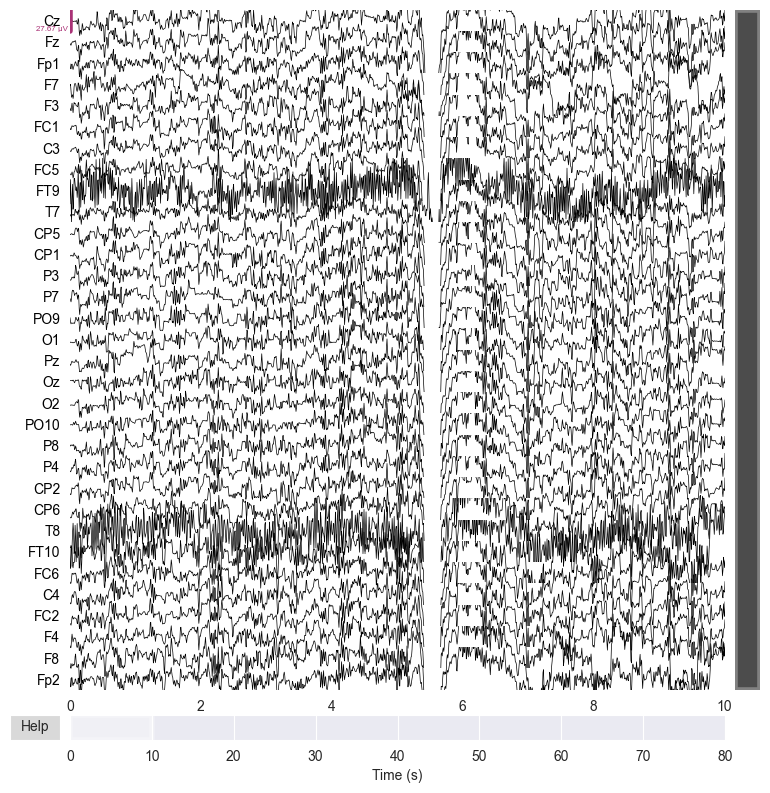

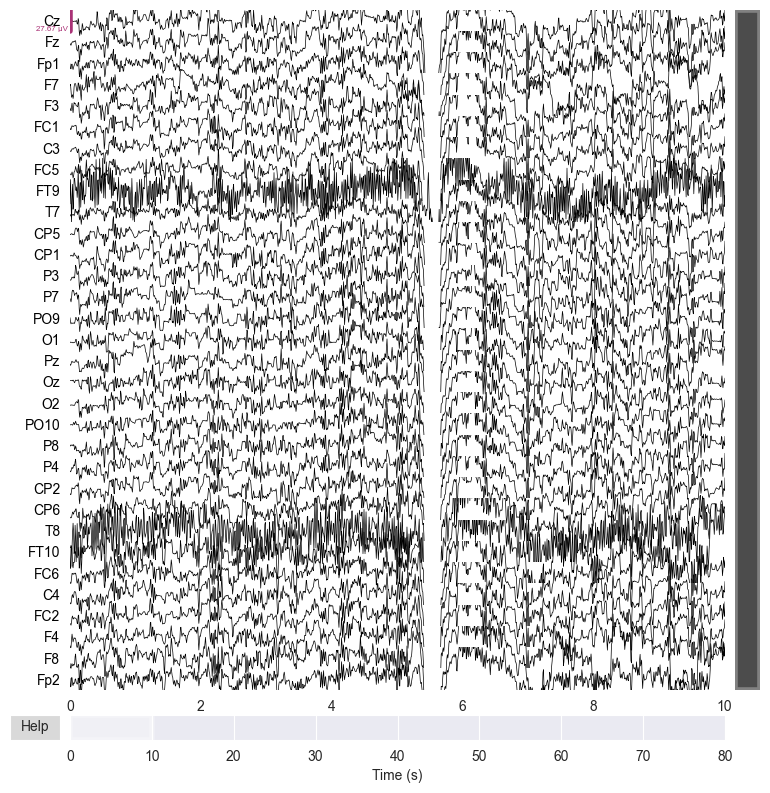

In [3]:
id=train_df['id'][0]
raw = mne.io.read_raw_fif(f'/Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Dataset/eremus_dataset/pruned/train/{id}_eeg.fif',preload=True)
raw.plot(n_channels=32, scalings='auto', title='Raw EEG Data', show=False, block=True)

filtered_data has the time series frequency component feature and each key i.e freq_band will house data of size 32x10240 (channel x timepoints)

In [4]:
from scipy.signal import butter, sosfilt

frequency_bands = {
    'Theta': (4, 8),
    'Alpha': (8, 14),
    'Beta': (14, 31),
    'Gamma': (31, 50)
}
filter_order = 30  # High order for sharper transitions

# Function to apply band-pass filter for each frequency band
def apply_bandpass_filter(data, lowcut, highcut, fs, order=filter_order):
    sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    return sosfilt(sos, data)

# Apply filters to each band
filtered_data = {}
for band, (lowcut, highcut) in frequency_bands.items():
    filtered_data[band] = apply_bandpass_filter(raw.get_data(), lowcut, highcut, fs=raw.info['sfreq'])

In [5]:
print(raw.get_data().shape)
raw.info['sfreq']

(32, 10240)


128.0

Plotting the filtered data to showcase the signal as different frequency bands components

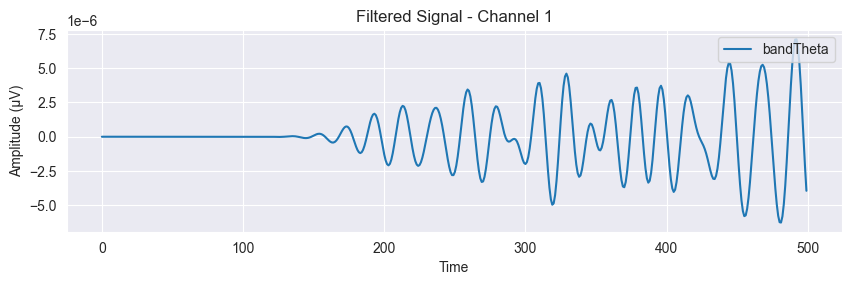

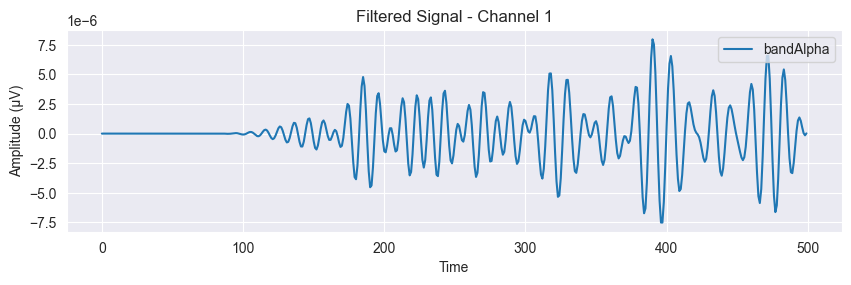

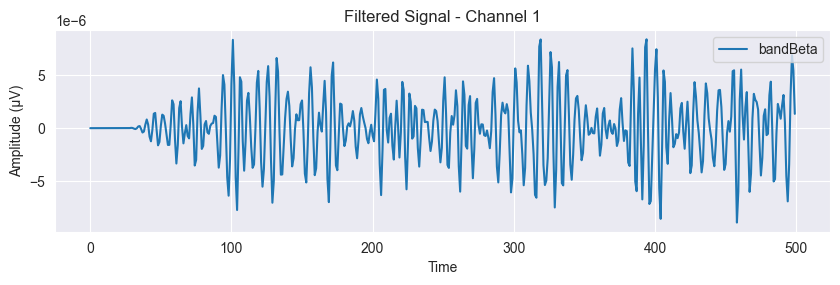

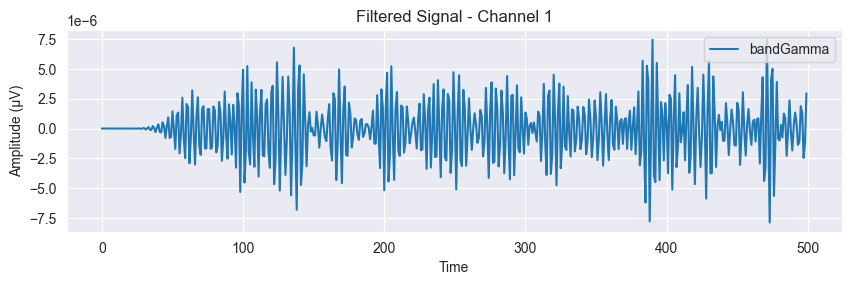

In [6]:
cur_band= 'Alpha'
n_channels = filtered_data[cur_band].shape[0]
time = np.arange(500)  # Assuming each sample represents one time unit

  # Adjust the figure size based on the number of channels

for i,_ in frequency_bands.items():
    plt.figure(figsize=(10,100))
    plt.subplot(n_channels, 1,  1)
    plt.plot(time, filtered_data[i][0][:500], label=f'band{i}')
    plt.xlabel("Time")
    plt.ylabel("Amplitude (µV)")
    plt.title(f"Filtered Signal - Channel {0+1}")
    plt.legend(loc="upper right")
    plt.show()

In [7]:
import numpy as np

# Define feature extraction functions
def min_max_normalize(feature):
    """Applies min-max normalization to a feature array """
    min_val = np.min(feature, axis=0, keepdims=True)
    max_val = np.max(feature, axis=0, keepdims=True)
    # Avoid division by zero
    return (feature - min_val) / (max_val - min_val + 1e-10)

def extract_features(segment):
    """Extracts time-domain features for a given EEG segment and normalizes each feature."""
    mean = np.mean(segment, axis=1)
    variance = np.var(segment, axis=1)
    std_dev = np.std(segment, axis=1)
    mean_diff1 = np.mean(np.diff(segment, n=1, axis=1), axis=1)
    mean_diff2 = np.mean(np.diff(segment, n=2, axis=1), axis=1)
    entropy = -np.sum(segment * np.log(np.abs(segment) + 1e-10), axis=1)  # Simple entropy measure
    
    # Stack features before normalization
    features = np.stack([mean, variance, std_dev, mean_diff1, mean_diff2, entropy], axis=1)
    # Apply min-max normalization to each feature
    #normalized_features = min_max_normalize(features) #Normalizes different channels against each other for each feature
    #But we want to normalize different segments against each other rather than the channels
    
    return features

In [8]:
# Parameters
segment_length = 1280  # Length of each segment, e.g., 1 second at 128 Hz
n_channels = filtered_data['Theta'].shape[0]  # Assuming 32 channels

# Initialize a dictionary to store features for each frequency band
features_by_band = {}

def min_max_normalize_batch(batch):
    """Applies min-max normalization across the batch of 32x6 matrices."""
    # Find min and max across the batch (axis=0) for each feature (columns)
    min_val = np.min(batch, axis=0, keepdims=True)  # Shape: (1, 32, 6)
    max_val = np.max(batch, axis=0, keepdims=True)  # Shape: (1, 32, 6)
    
    # Avoid division by zero by adding a small constant (1e-10)
    normalized_batch = (batch - min_val) / (max_val - min_val + 1e-10)
    
    return normalized_batch

for band, data in filtered_data.items():
    n_samples = data.shape[1]
    n_segments = n_samples // segment_length  # Number of segments per trial
    
    # Segment the data and extract features
    features = []
    for i in range(n_segments):
        segment = data[:, i*segment_length : (i+1)*segment_length]  # Non-overlapping segment
        band_features = extract_features(segment)  # Shape: (n_channels, n_features)
        features.append(band_features)
    #features.shape 8x32x6
    #Normalize segments against other segments rather than doing it against other channels of a segments
    normalized_features=min_max_normalize_batch(features)
    # Stack features across all segments for the current band
    features_by_band[band] = np.stack(normalized_features, axis=0)  # Shape: (n_segments, n_channels, n_features)

We have a 3d matrix in which we have a time feature for each channel of each segment

In [9]:
print(f'{n_segments}')
print(features_by_band['Theta'].shape)
print(features_by_band['Alpha'].shape)
print(features_by_band['Beta'].shape)
print(features_by_band['Gamma'].shape)

8
(8, 32, 6)
(8, 32, 6)
(8, 32, 6)
(8, 32, 6)


In [10]:
channel_order = raw.ch_names
print(channel_order)  # Lists channels in order as they appear in the array

['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']


In [11]:
wrong_order=[]
for idx, row in train_df.iterrows():
    raw=mne.io.read_raw_fif(f'/Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Dataset/eremus_dataset/pruned/train/{row["id"]}_eeg.fif',preload=True)
    if raw.ch_names!=channel_order:
        wrong_order.append(row["id"])
wrong_order

Opening raw data file /Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Dataset/eremus_dataset/pruned/train/3784258358_eeg.fif...
    Range : 9361 ... 19600 =     73.133 ...   153.125 secs
Ready.
Reading 0 ... 10239  =      0.000 ...    79.992 secs...
Opening raw data file /Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Dataset/eremus_dataset/pruned/train/2395445698_eeg.fif...
    Range : 20939 ... 31178 =    163.586 ...   243.578 secs
Ready.
Reading 0 ... 10239  =      0.000 ...    79.992 secs...
Opening raw data file /Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Dataset/eremus_dataset/pruned/train/3049220457_eeg.fif...
    Range : 32286 ... 42525 =    252.234 ...   332.227 secs
Ready.
Reading 0 ... 10239  =      0.000 ...    79.992 secs...
Opening raw data file /Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Dataset/eremus_dataset/pruned/train/2667905835_eeg.fif...
    Range : 44256 ... 54495 =    345.750 ...   425.742 secs
Ready.
Reading 0 ... 10239  =      0.000 ...    79.992 secs...
Openi

[]

ALL the channels are in the same order for all the training instances

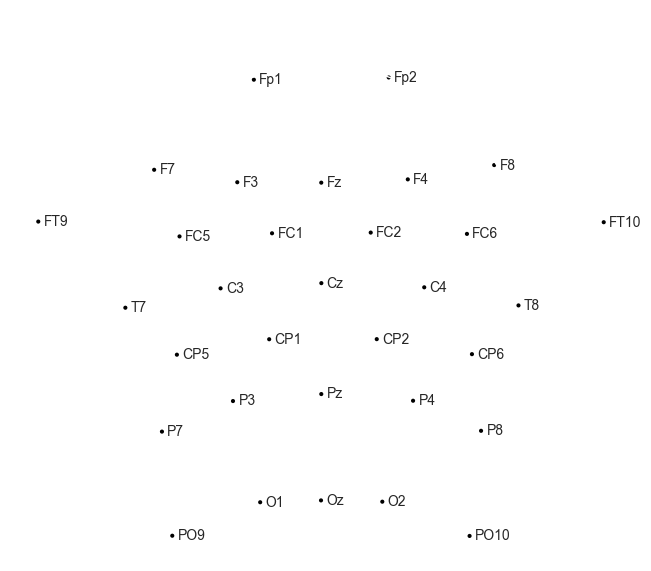

In [12]:
if not raw.info['chs'][0]['loc'].any():
    # If not, set a standard montage (e.g., 10-20 system)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)

fig = raw.plot_sensors(kind='topomap', show_names=True)

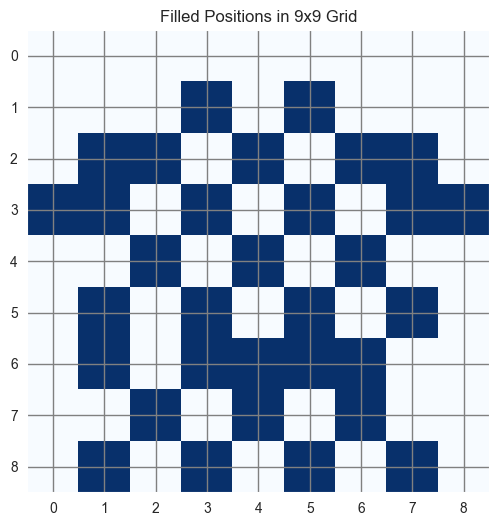

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Define the size of the grid
grid_size = 9

# Define the (row, col) positions in a 9x9 grid for each of the 32 EEG channels.
electrode_positions = [
    (4, 4),  # Cz (center)
    (2, 4),  # Fz
    (1, 3),  # Fp1
    (2, 1),  # F7
    (2, 2),  # F3
    (3, 3),  # FC1
    (4, 2),  # C3
    (3, 1),  # FC5
    (3, 0),  # FT9
    (5, 1),  # T7
    (6, 1),  # CP5
    (5, 3),  # CP1
    (6, 3),  # P3
    (7, 2),  # P7
    (8, 1),  # PO9
    (8, 3),  # O1
    (6, 4),  # Pz
    (7, 4),  # Oz
    (8, 5),  # O2
    (8, 7),  # PO10
    (7, 6),  # P8
    (6, 5),  # P4
    (5, 5),  # CP2
    (6, 6),  # CP6
    (5, 7),  # T8
    (3, 8),  # FT10
    (3, 7),  # FC6
    (4, 6),  # C4
    (3, 5),  # FC2
    (2, 6),  # F4
    (2, 7),  # F8
    (1, 5),  # Fp2
]
# Initialize a 9x9 grid with all zeros
grid = np.zeros((grid_size, grid_size))

# Mark filled positions with a value of 1
for pos in electrode_positions:
    grid[pos] = 1

# Plot the grid
plt.figure(figsize=(6, 6))
plt.imshow(grid, cmap="Blues", origin='upper')

# Customize the plot
plt.title("Filled Positions in 9x9 Grid")
plt.xticks(range(grid_size))
plt.yticks(range(grid_size))
plt.grid(which='both', color='gray', linestyle='-', linewidth=1)
plt.show()

In [14]:
def create_spatial_matrix(feature_data, n_channels=32, grid_size=(9, 9)):
    """Maps the features into a 2D grid layout based on the EEG electrode arrangement."""
    spatial_matrix = np.zeros(grid_size + (feature_data.shape[1],))  # (9, 9, n_features)
    
    for idx, pos in enumerate(electrode_positions):
        spatial_matrix[pos[0], pos[1], :] = feature_data[idx, :]  # Assign features at each electrode position
    
    return spatial_matrix

# Combine features from all bands into a single 18x18 matrix 
dataset = []
for i in range(n_segments):
    # Initialize a 18x18x6 matrix
    combined_features = np.zeros((18, 18, 6))

    # Create the spatial matrix for each frequency band
    theta_matrix = create_spatial_matrix(features_by_band['Theta'][i], n_channels=32)
    alpha_matrix = create_spatial_matrix(features_by_band['Alpha'][i], n_channels=32)
    beta_matrix = create_spatial_matrix(features_by_band['Beta'][i], n_channels=32)
    gamma_matrix = create_spatial_matrix(features_by_band['Gamma'][i], n_channels=32)
    
    # Place each 9x9 frequency matrix into the appropriate quadrant of the 18x18 matrix
    combined_features[0:9, 0:9, :] = theta_matrix  # Top-left quadrant
    combined_features[0:9, 9:18, :] = alpha_matrix  # Top-right quadrant
    combined_features[9:18, 0:9, :] = beta_matrix  # Bottom-left quadrant
    combined_features[9:18, 9:18, :] = gamma_matrix  # Bottom-right quadrant
    
    # Append the final 18x18x6 matrix for this segment
    dataset.append(combined_features)

# Convert to numpy array for training
dataset = np.array(dataset)  # Shape: (n_segments, 18, 18, 6)

In [15]:
dataset.shape

(8, 18, 18, 6)

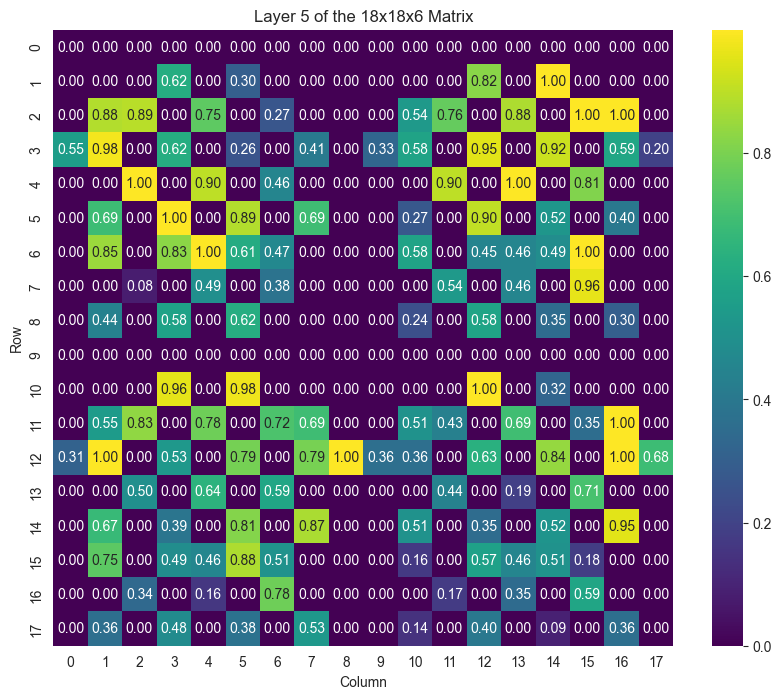

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

input_mat = dataset[0]

# Choose the layer to plot, e.g., layer 0
layer = 5
matrix_layer = input_mat[:, :, layer]

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(matrix_layer, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title(f"Layer {layer} of the 18x18x6 Matrix")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()

Individual input seems to be in the right orientation

Get the output labels and the training matrices for all the training data

In [17]:
train_df

,id,label
0,3784258358,0
1,2395445698,2
2,3049220457,3
3,2667905835,3
4,1281311748,0
...,...,...
218,7081425536,1
219,5527955318,1
220,1424199427,0
221,3966019638,3


Function to preprocess each id and return a list of (segment_matrix,label) tuples

In [32]:
# Preprocessing function for each EEG signal ID
def preprocess_id(id, label, segment_length=1280):
    # Load EEG data
    raw = mne.io.read_raw_fif(f'/Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Dataset/eremus_dataset/pruned/train/{id}_eeg.fif', preload=True)
    
    # Apply bandpass filtering for each frequency band
    filtered_data = {}
    for band, (lowcut, highcut) in frequency_bands.items():
        filtered_data[band] = apply_bandpass_filter(raw.get_data(), lowcut, highcut, fs=raw.info['sfreq'])
    
    # Extract features and map to 18x18x6 matrix
    features_by_band = {}
    
    for band, data in filtered_data.items():
        n_samples = data.shape[1]
        n_segments = n_samples // segment_length
        segment_data = []
        for i in range(n_segments):
            segment = data[:, i * segment_length : (i + 1) * segment_length]
            band_features = extract_features(segment)
            segment_data.append(band_features)
        # normalized_segment_data=min_max_normalize_batch(segment_data)
        features_by_band[band] = np.stack(segment_data, axis=0)
    combined_features=[]
    combined_labels=[]
    for i in range(n_segments):
        # Initialize a 18x18x6 matrix
        combined_matrix = np.zeros((18, 18, 6))
    
        # Create the spatial matrix for each frequency band
        theta_matrix = create_spatial_matrix(features_by_band['Theta'][i], n_channels=32)
        alpha_matrix = create_spatial_matrix(features_by_band['Alpha'][i], n_channels=32)
        beta_matrix = create_spatial_matrix(features_by_band['Beta'][i], n_channels=32)
        gamma_matrix = create_spatial_matrix(features_by_band['Gamma'][i], n_channels=32)
        
        # Place each 9x9 frequency matrix into the appropriate quadrant of the 18x18 matrix
        combined_matrix[0:9, 0:9, :] = theta_matrix  # Top-left quadrant
        combined_matrix[0:9, 9:18, :] = alpha_matrix  # Top-right quadrant
        combined_matrix[9:18, 0:9, :] = beta_matrix  # Bottom-left quadrant
        combined_matrix[9:18, 9:18, :] = gamma_matrix  # Bottom-right quadrant
        combined_features.append(combined_matrix)
        combined_labels.append(label)
    
    return combined_features,combined_labels


In [48]:
segment_dataset = []
label_dataset = []
for idx, row in train_df.iterrows():
    id, label = row['id'], row['label']
    segment_data,label_data = preprocess_id(id, label)
    segment_dataset.extend(segment_data)
    label_dataset.extend(label_data)
segment_dataset=np.array(segment_dataset)
normalized_segment_dataset=min_max_normalize_batch(segment_dataset)
segment_df = pd.DataFrame({'input_matrix': list(normalized_segment_dataset), 'label': label_dataset})

Opening raw data file /Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Dataset/eremus_dataset/pruned/train/3784258358_eeg.fif...
    Range : 9361 ... 19600 =     73.133 ...   153.125 secs
Ready.
Reading 0 ... 10239  =      0.000 ...    79.992 secs...
Opening raw data file /Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Dataset/eremus_dataset/pruned/train/2395445698_eeg.fif...
    Range : 20939 ... 31178 =    163.586 ...   243.578 secs
Ready.
Reading 0 ... 10239  =      0.000 ...    79.992 secs...
Opening raw data file /Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Dataset/eremus_dataset/pruned/train/3049220457_eeg.fif...
    Range : 32286 ... 42525 =    252.234 ...   332.227 secs
Ready.
Reading 0 ... 10239  =      0.000 ...    79.992 secs...
Opening raw data file /Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Dataset/eremus_dataset/pruned/train/2667905835_eeg.fif...
    Range : 44256 ... 54495 =    345.750 ...   425.742 secs
Ready.
Reading 0 ... 10239  =      0.000 ...    79.992 secs...
Openi

In [49]:
(segment_dataset).shape

(1977, 18, 18, 6)

In [50]:
segment_df.shape

(1977, 2)

In [51]:
segment_df['input_matrix'][0].shape

(18, 18, 6)

In [52]:
segment_df.label.unique()

array([0, 2, 3, 1])

Shuffling the dataset

In [53]:
segment_df=segment_df.sample(frac=1).reset_index(drop=True)

In [54]:
segment_df.shape

(1977, 2)

In [55]:
segment_df['input_matrix'][0].shape

(18, 18, 6)

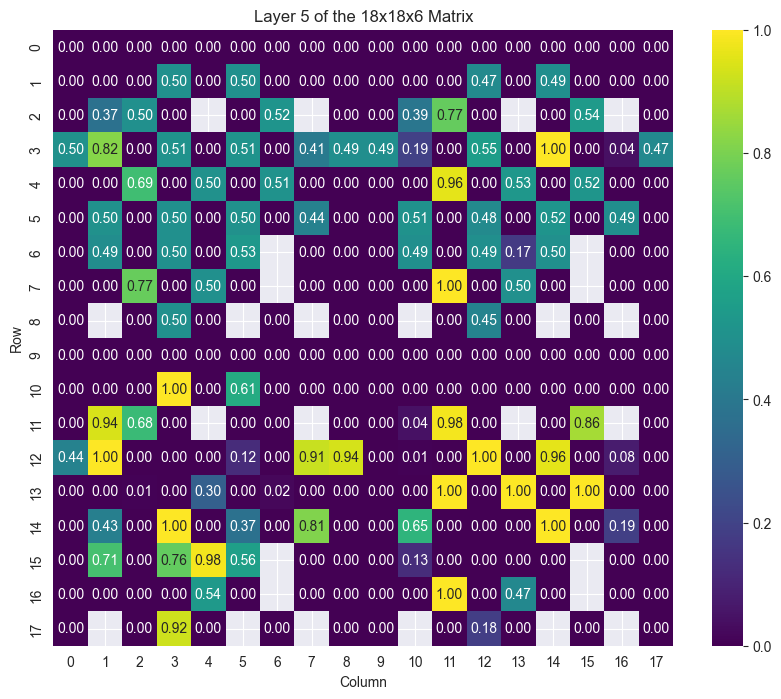

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

input_mat = segment_df['input_matrix'][5]

# Choose the layer to plot, e.g., layer 0
layer = 5
matrix_layer = input_mat[:, :, layer]

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(matrix_layer, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title(f"Layer {layer} of the 18x18x6 Matrix")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()

In [65]:
# Separate 'input_matrix' column and 'label' column
input_matrix_array = np.array(segment_df['input_matrix'].tolist())  # Convert input_matrix column to a 3D NumPy array
labels = segment_df['label']  # Get the labels as a Series

# Save the input matrix as a .npy file
np.save('dataset/new_input_matrix.npy', input_matrix_array)

# Save the labels as a CSV
labels.to_csv('dataset/new_labels.csv', index=False)

In [ ]:
input_mat[:,:,0].shape

Checking prepared dataset

In [ ]:
sns.countplot(x=segment_df['label'])
plt.title("Label Distribution")
plt.show()

Training a simple CNN model to check if issue with data or the model

Epoch 1/100


/Users/harsh_dadwal/Harsh/Research_signal/A.Purohit/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3032 - loss: nan - val_accuracy: 0.3005 - val_loss: nan
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2792 - loss: nan - val_accuracy: 0.3005 - val_loss: nan
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3027 - loss: nan - val_accuracy: 0.3005 - val_loss: nan
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2948 - loss: nan - val_accuracy: 0.3005 - val_loss: nan
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3160 - loss: nan - val_accuracy: 0.3005 - val_loss: nan
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3258 - loss: nan - val_accuracy: 0.3005 - val_loss: nan
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2893 - loss: nan - val_accuracy: 0.3005 - val_loss: nan
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3202 - loss: nan - val_accuracy: 0.3005 - val_loss: nan
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5m

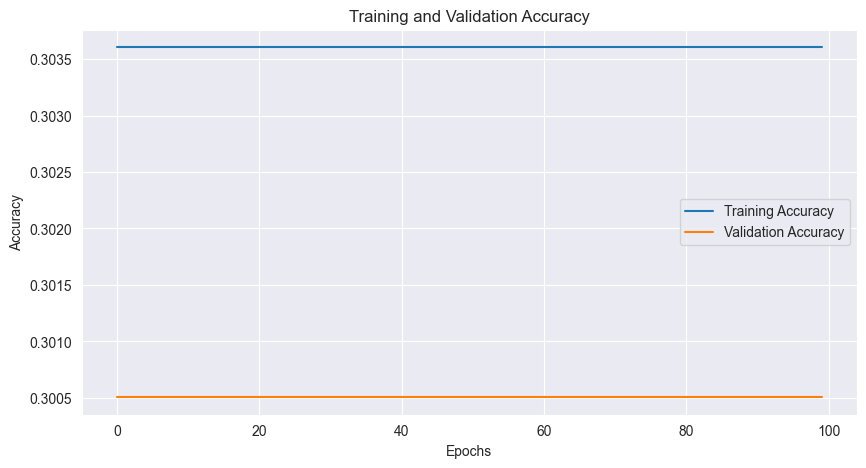

In [57]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming `df` is the DataFrame containing 'input_matrix' and 'label' columns
# Prepare the data
X = np.stack(segment_df['input_matrix'].values)  # Shape: (num_samples, 18, 18, 6)
y = tf.keras.utils.to_categorical(segment_df['label'], num_classes=4)  # One-hot encoding of labels

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a simple CNN model
def build_simple_cnn(input_shape=(18, 18, 6), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Compile and train the model
model = build_simple_cnn()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Increase if necessary
    batch_size=32,
    verbose=1
)

# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()